# Project 1: Classifying Music Genre by Lyrics


# Anthony is here

# Laura is here

In [2]:
from lyricsgenius import Genius
import os
import json
import re
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
# Loading the JSON file
with open("data.json", "r", encoding="utf-8") as f:
    data = json.load(f)

In [4]:
# Extracting all genres from the JSON
genres = []
for song_id, song_info in data.items():
    genres.append(song_info["genre"])

In [5]:
# Counting how many of each genre
genre_counts = Counter(genres)

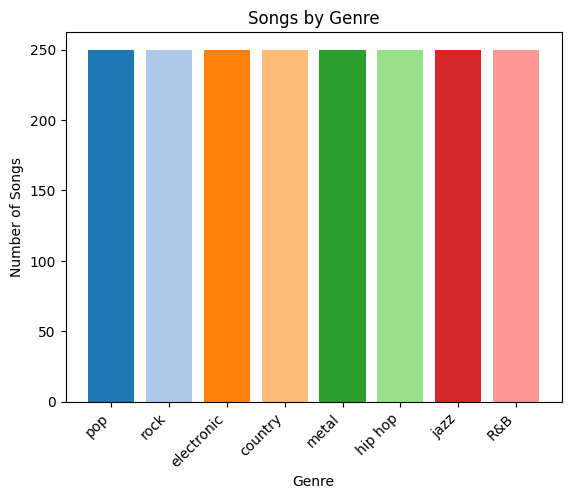

In [6]:
# Plotting a bar chart

colors = plt.cm.tab20.colors  # a palette with 20 distinct colors
bar_colors = [colors[i % len(colors)] for i in range(len(genre_counts))]
plt.bar(genre_counts.keys(), genre_counts.values(), color=bar_colors)
plt.xlabel("Genre")
plt.ylabel("Number of Songs")
plt.title("Songs by Genre")

# Rotate x-axis labels to avoid overlap
plt.xticks(rotation=45, ha='right')

plt.show()

In [7]:
# Sorting the songs by genre
songs_grouped_by_genre = defaultdict(list)

for song_id, song_info in data.items():
    songs_grouped_by_genre[song_info["genre"]].append(song_info)


In [8]:
# Clean the data and prepare for vectorization
def clean_lyrics(lyrics, 
                 keep_linebreaks=False, 
                 lowercase=True, 
                 remove_punctuation=True):
    """
    Cleans song lyrics for vectorization.

    Parameters:
    - lyrics (str): the raw lyrics
    - keep_linebreaks (bool): whether to keep '\n' for stanza separation
    - lowercase (bool): whether to convert all text to lowercase
    - remove_punctuation (bool): whether to strip punctuation

    Returns:
    - str: cleaned lyrics
    """
    if lyrics is None:
        return ""

    # Replace unicode formatting spaces with normal space
    lyrics = lyrics.replace('\u2005', ' ').replace('\xa0', ' ')

    # Optionally replace newlines with space
    if not keep_linebreaks:
        lyrics = lyrics.replace('\n', ' ')

    # Lowercase
    if lowercase:
        lyrics = lyrics.lower()

    # Remove punctuation
    if remove_punctuation:
        lyrics = re.sub(r"[^\w\s]", "", lyrics)

    # Normalize multiple spaces
    lyrics = re.sub(r"\s+", " ", lyrics).strip()

    return lyrics

for genre in songs_grouped_by_genre:
    current_genre_songs = songs_grouped_by_genre[genre]
    for song in current_genre_songs:
        if song.get("lyrics") is None:
            continue
        song["lyrics"] = clean_lyrics(song["lyrics"])

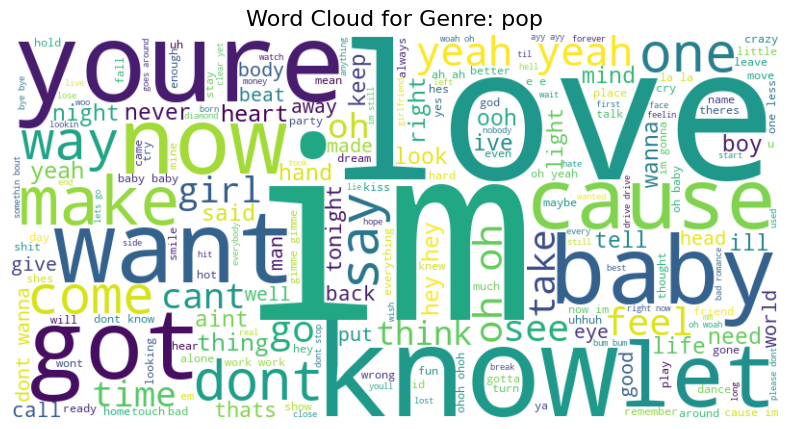

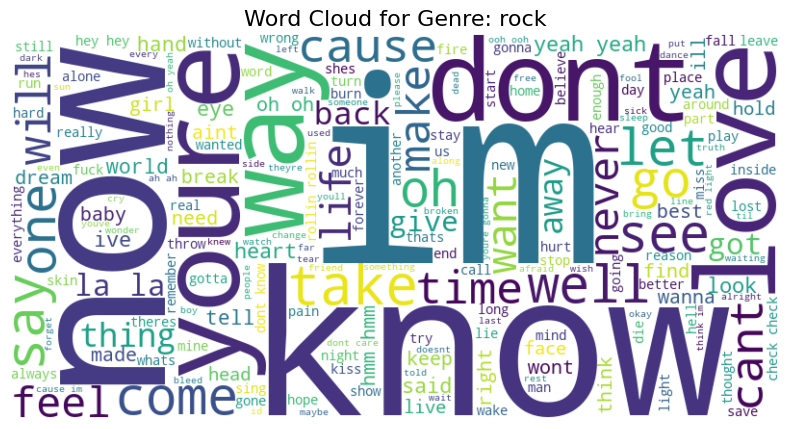

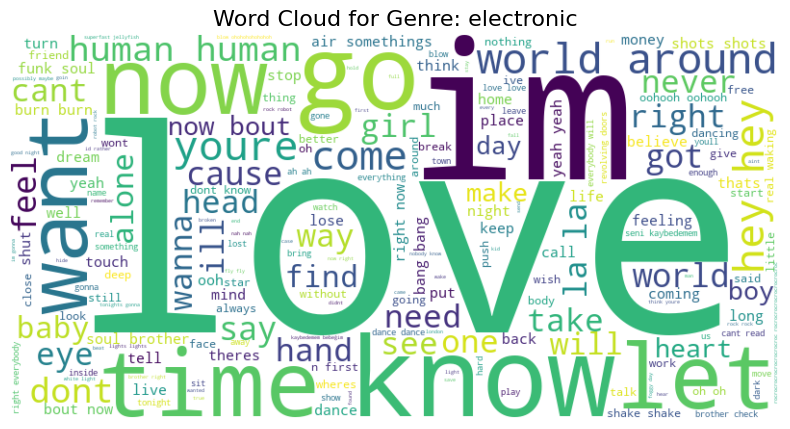

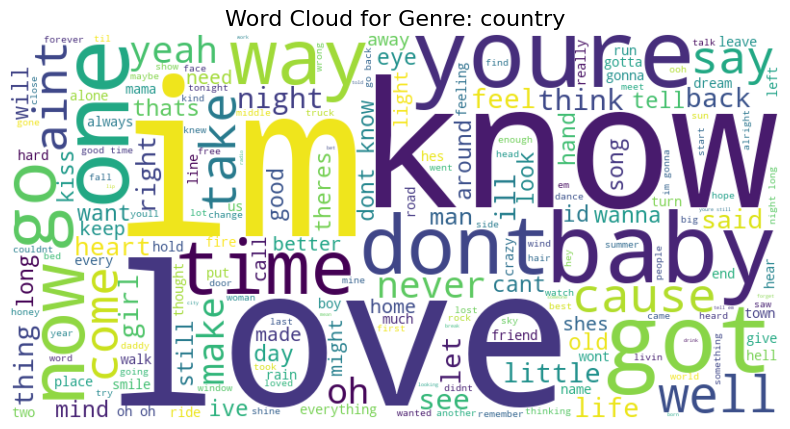

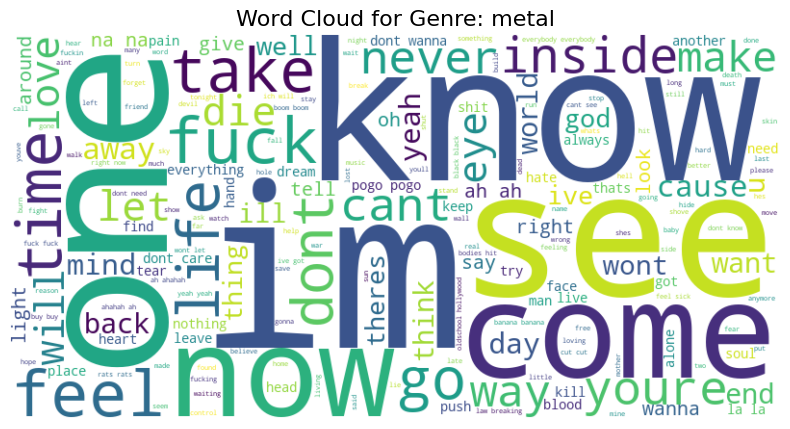

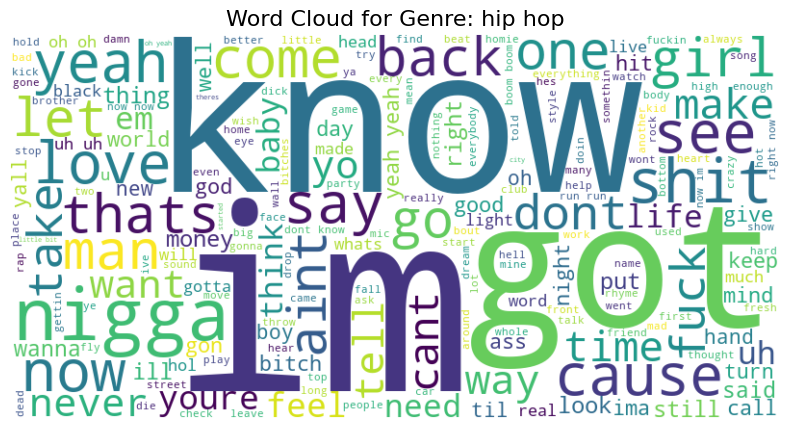

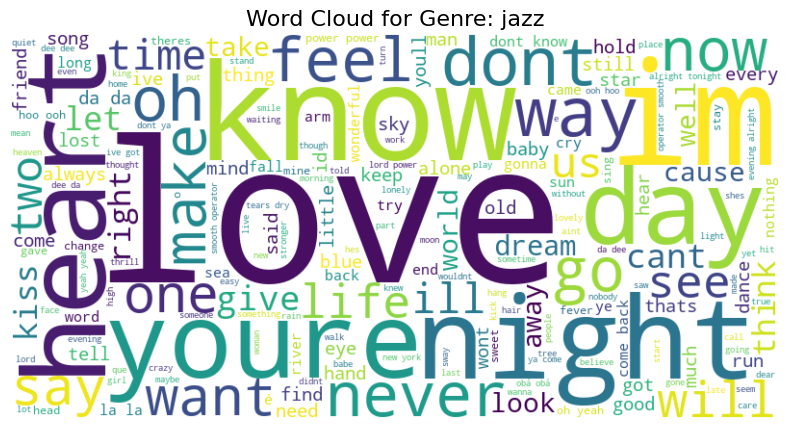

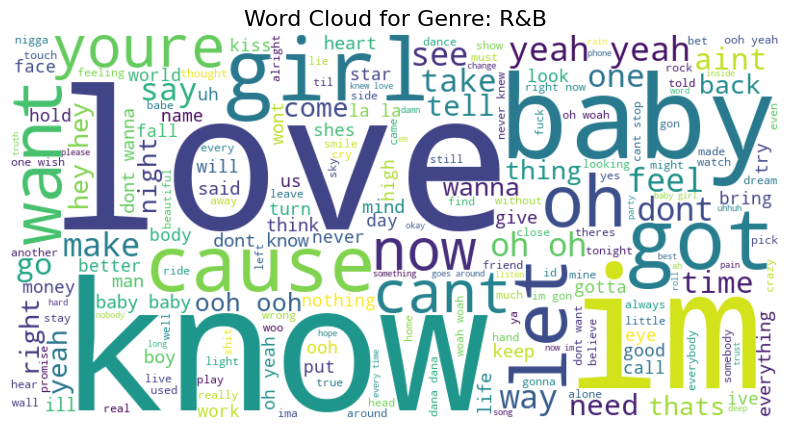

In [9]:
# Generating word cloud for each genre
for genre in songs_grouped_by_genre:
    # Collect all lyrics for this genre into one big string
    lyrics_list = []
    for song in songs_grouped_by_genre[genre]:
        if song.get("lyrics") is not None and song["lyrics"].strip():
            lyrics_list.append(song["lyrics"])
    
    if not lyrics_list:  # skip if no valid lyrics
        continue
    
    lyrics_text = " ".join(lyrics_list)

    # Generate word cloud
    wc = WordCloud(width=800, height=400, background_color="white").generate(lyrics_text)

    # Plot
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for Genre: {genre}", fontsize=16)
    plt.show()

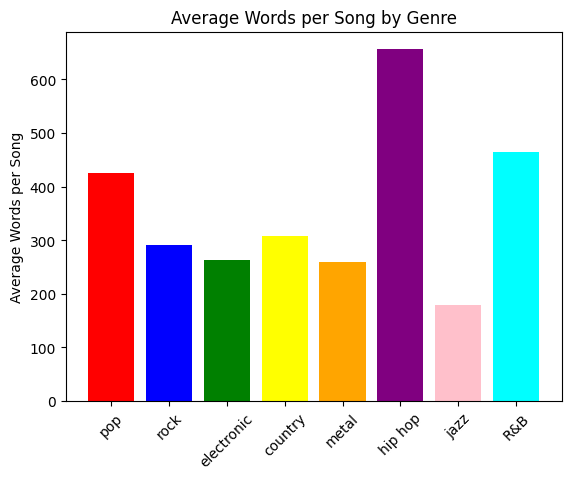

In [10]:
# Average number of words per song for each genre
avg_words_per_genre = {}

for genre, songs in songs_grouped_by_genre.items():
    word_counts = []
    for song in songs:
        lyrics = song.get("lyrics")
        if lyrics and lyrics.strip():  # only count if lyrics exist
            words = lyrics.split()  # split on whitespace
            word_counts.append(len(words))
    
    if word_counts:  # avoid division by zero
        avg_words_per_genre[genre] = sum(word_counts) / len(word_counts)
    else:
        avg_words_per_genre[genre] = 0

plt.bar(avg_words_per_genre.keys(), avg_words_per_genre.values(), color=["red", "blue", "green", "yellow", "orange", "purple", "pink", "aqua"])
plt.ylabel("Average Words per Song")
plt.title("Average Words per Song by Genre")
plt.xticks(rotation=45)
plt.show()

In [13]:
# tf-idf extract features

# Flatten the dictionary to a list of lyrics and their genres
lyrics_list = []
genres_list = []

for genre, songs in songs_grouped_by_genre.items():
    for song in songs:
        lyrics = song.get("lyrics")
        if lyrics and lyrics.strip():  # only include non-empty lyrics
            lyrics_list.append(lyrics)
            genres_list.append(genre)

tfidf_vectorizer = TfidfVectorizer(
    lowercase=True,        # already done in preprocessing, but safe
    stop_words='english',  # remove common words
    ngram_range=(1, 2),    # unigrams + bigrams
    max_features=5000      # optional: limit to top 5000 features
)